In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

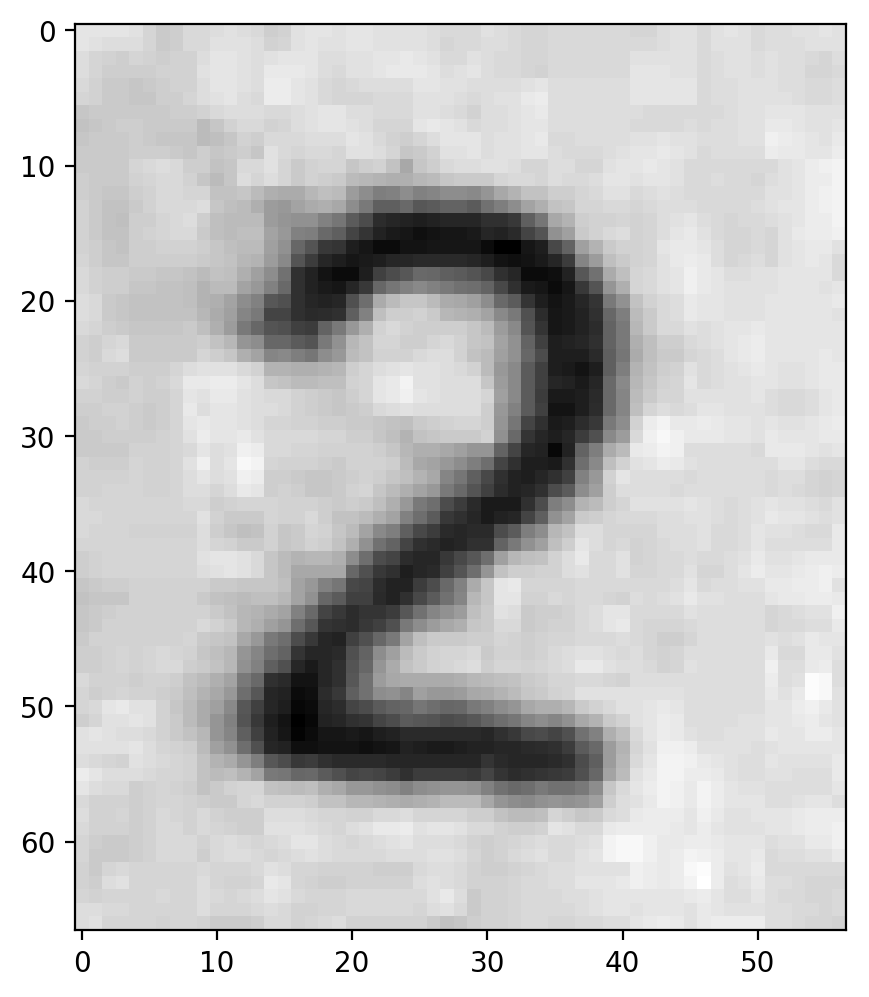

In [2]:
karakter = 'C'
img = cv2.imread('2.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(8, 6), dpi=200)
plt.imshow(img, cmap='gray')
plt.show()

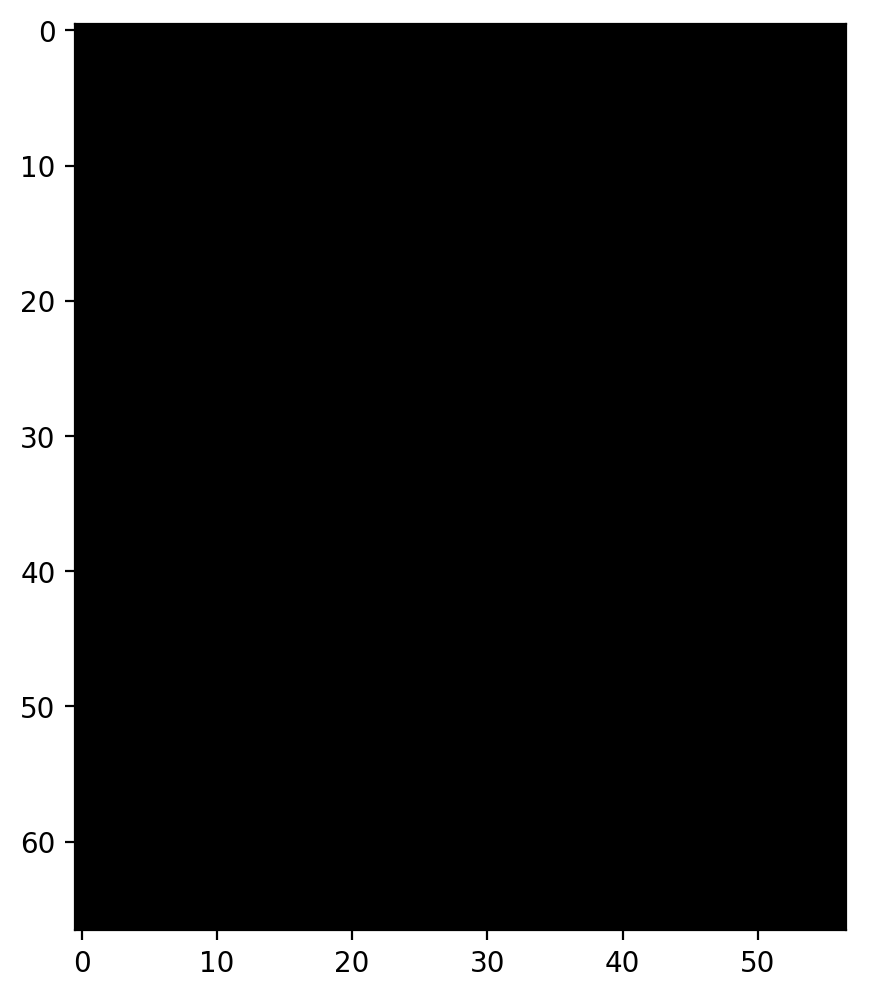

In [25]:
def to_rgb(img):
    h, w = img.shape
    res = np.ones((h,w,3))
    for y in range(h):
        for x in range(w):
            res[y][x] *= img[y][x]
    return res.astype(np.uint8)

def to_grayscale(img):
    return np.vectorize(lambda x: 255 if x == 0 else 0)(img)

def to_bitmap(img, threshold=110):
    return np.vectorize(lambda x: 1 if x < threshold else 0)(img)

threshold = 20
img_binary = np.vectorize(lambda x: 255 if x > threshold else 0)(img)

plt.figure(figsize=(8, 6), dpi=200)
plt.imshow(img_binary, cmap='gray')
plt.show()

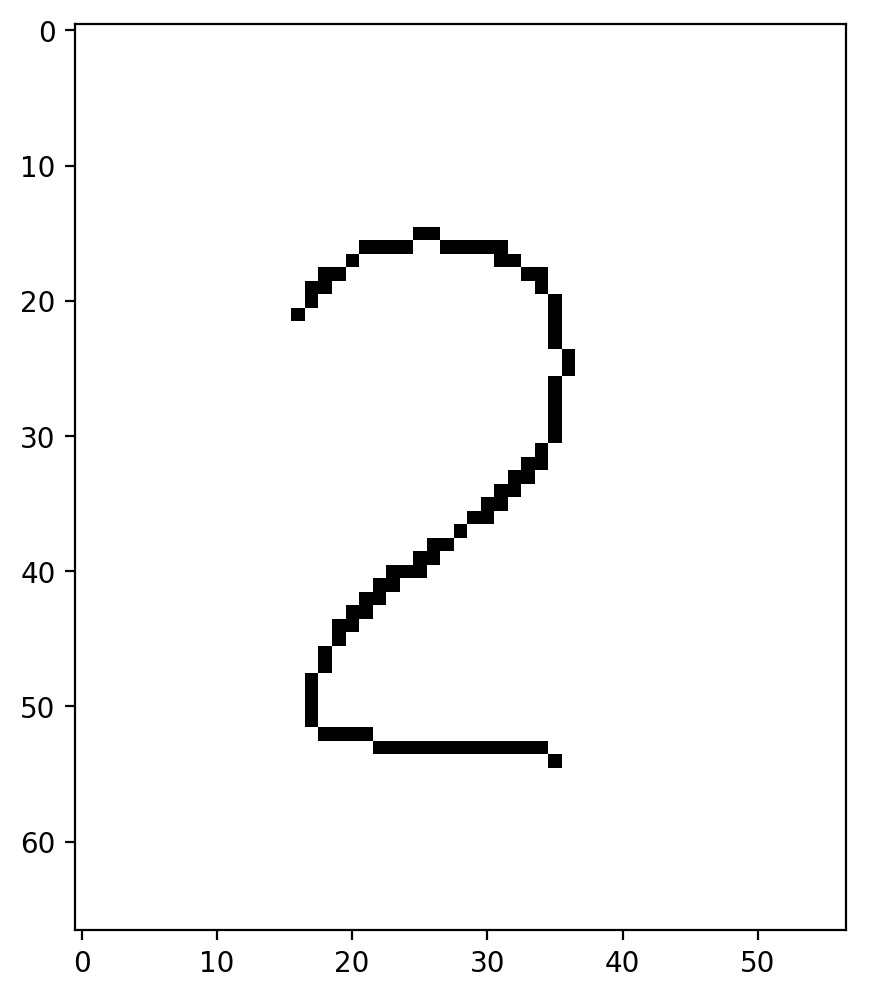

In [4]:
def generate_neighbour(img, y, x):
    h, w = img.shape
    p2 = img[y-1][x] if y > 0 else 0
    p3 = img[y-1][x+1] if y > 0 and x < w-1 else 0
    p4 = img[y][x+1] if x < w-1 else 0
    p5 = img[y+1][x+1] if y < h-1 and x < w-1 else 0
    p6 = img[y+1][x] if y < h-1 else 0
    p7 = img[y+1][x-1] if y < h-1 and x > 0 else 0
    p8 = img[y][x-1] if x > 0 else 0
    p9 = img[y-1][x-1] if y > 0 and x > 0 else 0
    return [p2,p3,p4,p5,p6,p7,p8,p9]

def check_delete(image, y, x):
    if image[y][x] == 0:
        return False
    ps = generate_neighbour(image, y, x)
    np = len(list(filter(lambda x : x != 0, ps)))
    sp = 0
    for i in range(len(ps)):
        j = (i + 1) % len(ps)
        sp += 1 if ps[i] != 0 and ps[j] == 0 else 0
    ret = (2 <= np) and (np <= 6) and (sp == 1) and (ps[2] == 0 or ps[4] == 0 or (ps[0] == 0 and ps[6] == 0))
    return ret

def check_delete_2(image, y, x):
    if image[y][x] == 0:
        return False
    ps = generate_neighbour(image, y, x)
    np = len(list(filter(lambda x : x != 0, ps)))
    sp = 0
    for i in range(len(ps)):
        j = (i + 1) % len(ps)
        sp += 1 if ps[i] != 0 and ps[j] == 0 else 0
    ret = (2 <= np) and (np <= 6) and (sp == 1) and (ps[0] == 0 or ps[6] == 0 or (ps[2] == 0 and ps[4] == 0))
    return ret

def thinning(img):
    height, width = img.shape
    img = img.copy()
    change = True
    while change:
        must_delete = []
        change = False
        for y in range(height):
            for x in range(width):
                if check_delete(img, y, x):
                    change = True
                    must_delete += [(x,y)]
        for v in must_delete:
            img[v[1]][v[0]] = 0

        must_delete = []
        for y in range(height):
            for x in range(width):
                if check_delete_2(img, y, x):
                    change = True
                    must_delete += [(x,y)]
        for v in must_delete:
            img[v[1]][v[0]] = 0
        must_delete = []
    return img

img_binary = to_bitmap(img)
img_thinned = thinning(img_binary)

plt.figure(figsize=(8, 6), dpi=200)
plt.imshow(to_grayscale(img_thinned), cmap='gray')
plt.show()

corners: 2
intersections: 0


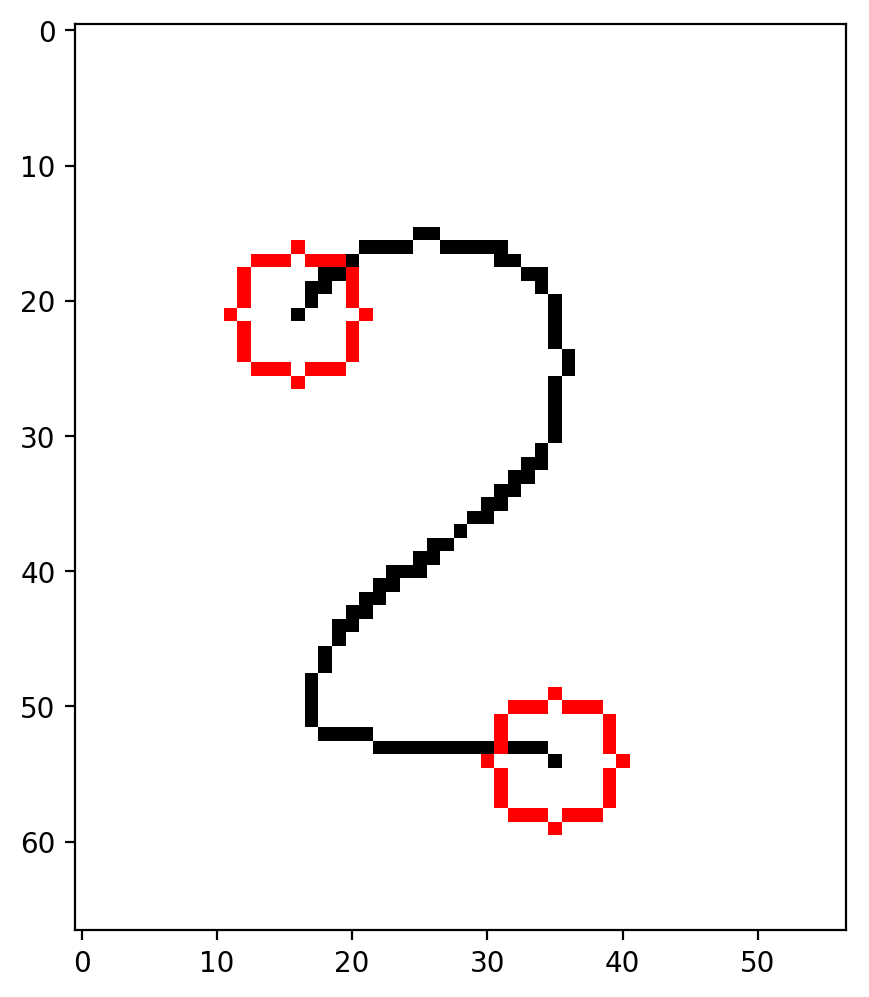

In [5]:
def is_corner(img, y, x):
    return img[y][x] != 0 and sum(generate_neighbour(img, y, x)) == 1

def is_intersection(img, y, x):
    neighbours = generate_neighbour(img, y, x)
    n = sum(neighbours)
    sp = 0
    for i in range(len(neighbours)):
        j = (i + 1) % len(neighbours)
        sp += 1 if neighbours[i] != 0 and neighbours[j] == 0 else 0
    return img[y][x] != 0 and n > 2 and sp > 2

def get_corner_and_intersection(img):
    h, w = img.shape
    corners = []
    intersections = []
    for y in range(h):
        for x in range(w):
            if is_corner(img, y, x):
                corners += [(x, y)]
            if is_intersection(img, y, x):
                intersections += [(x, y)]
    return corners, intersections

img_points = to_rgb(to_grayscale(img_thinned))
corners, intersections = get_corner_and_intersection(img_thinned)
for x, y in corners:
    cv2.circle(img_points, (x, y), 5, (255,0,0))
for x, y in intersections:
    cv2.circle(img_points, (x, y), 5, (0,0,255))
    
print("corners: %d" % len(corners))
print("intersections: %d" % len(intersections))

plt.figure(figsize=(8, 6), dpi=200)
plt.imshow(img_points)
plt.show()

[0.08928571 0.07142857 0.17857143 0.04464286 0.10204082 0.11904762
 0.17708333 0.08333333 0.06944444]
[[(16, 21), (35, 54)]]
[[]]
[0.08928571428571429, 0.07142857142857142, 0.17857142857142858, 0.044642857142857144, 0.10204081632653061, 0.11904761904761904, 0.17708333333333334, 0.08333333333333333, 0.06944444444444445, 2, 0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.525, 'C']


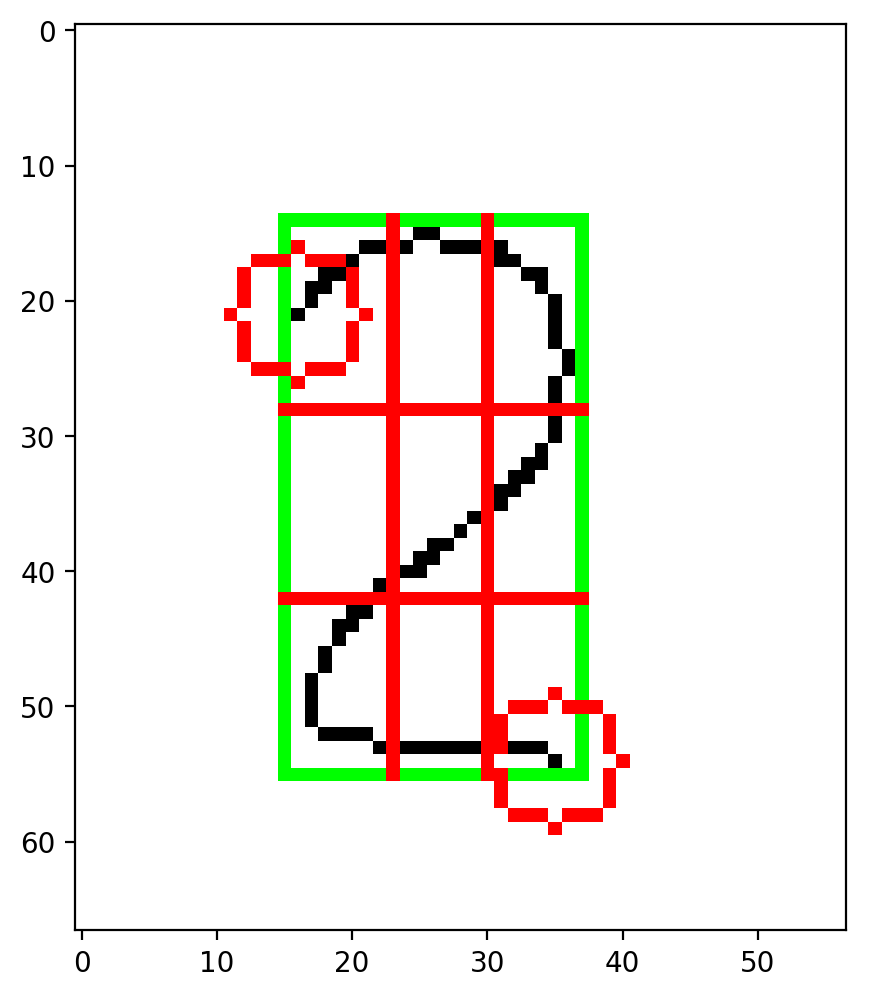

In [23]:
def locate_point_in_grid(array, x, y, x2, x3, y2, y3):
    if y <= y2:
        if x <= x2:
            array[0] += 1
        elif x > x2 and x <= x3:
            array[1] += 1
        else:
            array[2] += 1
    elif y > y2 and y <= y3:
        if x <= x2:
            array[3] += 1
        elif x > x2 and x <= x3:
            array[4] += 1
        else:
            array[5] += 1
    else:
        if x <= x2:
            array[6] += 1
        elif x > x2 and x <= x3:
            array[7] += 1
        else:
            array[8] += 1
            
def get_objects_corners_and_intersections(img):
    img = img.copy()
    visited = np.zeros(img.shape)
    h, w = img.shape
    dx = [0, 1, 1, 1, 0, -1, -1, -1]
    dy = [-1, -1, 0, 1, 1, 1, 0, -1]
    
    res_corners = []
    res_intersections = []
    res_upper_bound = []
    res_lower_bound = []
    
    for y in range(h):
        for x in range(w):
            if img[y][x] != 0:
                
                corners = []
                intersections = []
                upper_bound = (w, h)
                lower_bound = (0, 0)
                perimeter = 0
                
                stack = [(x,y)]
                while len(stack) > 0:
                    cx, cy = stack.pop()
                    if visited[cy][cx] == 1:
                        continue
                    visited[cy][cx] = 1
                    
                    upper_bound = (min(cx, upper_bound[0]), min(cy, upper_bound[1]))
                    lower_bound = (max(cx, lower_bound[0]), max(cy, lower_bound[1]))
                    perimeter += 1
                    if is_corner(img, cy, cx):
                        corners.append((cx, cy))
                    if is_intersection(img, cy, cx):
                        intersections.append((cx, cy))
                        
                    for ddx, ddy in zip(dx, dy):
                        nx = cx + ddx
                        ny = cy + ddy
                        if nx >= 0 and nx < w and ny >= 0 and ny < h and visited[ny][nx] == 0 and img[ny][nx] != 0:
                            stack.append((nx, ny))
                            
                # remove some corners
                real_corners = []
                for i, corner in enumerate(corners):
                    real_corners += [corner]
                    for intersect in intersections:
                        # there is intersection point near this corner point
                        if np.linalg.norm(np.array(corner)-np.array(intersect)) < perimeter * 0.05:
                            real_corners.pop()
                            
                            # remove corner until the corner are gone
                            current_corner = corner
                            s = 1
                            while s == 1:
                                img[current_corner[1]][current_corner[0]] = 0
                                ns = generate_neighbour(img, current_corner[1], current_corner[0])
                                s = 0
                                for direction_i, val in enumerate(ns):
                                    s += val
                                    if val > 0:
                                        current_corner = (
                                            current_corner[0] + dx[direction_i],
                                            current_corner[1] + dy[direction_i]
                                        )
                                        
                            break
                                        
                # recalculate intersections
                real_intersections = []
                for intersection in intersections:
                    if is_intersection(img, intersection[1], intersection[0]):
                        real_intersections += [intersection]
                
                if perimeter > 20:
                    res_upper_bound.append(upper_bound)
                    res_lower_bound.append(lower_bound)
                    res_corners.append(real_corners)
                    res_intersections.append(real_intersections)
                
    return res_corners, res_intersections, res_upper_bound, res_lower_bound

def get_ratio_bound(upper_bound, lower_bound):
    return (((lower_bound[0] + 1) - upper_bound[0]) / ((lower_bound[1] + 1) - upper_bound[1]))

def generate_other_feature(array):
    vertical_3 = np.zeros(3)
    horizontal_3 = np.zeros(3)
    for i in range(3):
        vertical_3[i] = (array[i] + array[i+3] + array[i+6])
        horizontal_3[i] = (array[i*3] + array[i*3+1] + array[i*3+2])
    four_grid = np.zeros(4)
    four_grid[0] = array[0] + array[1] + array[3] + array[4]
    four_grid[1] = array[1] + array[2] + array[4] + array[5]
    four_grid[2] = array[3] + array[4] + array[6] + array[7]
    four_grid[3] = array[4] + array[5] + array[7] + array[8]
    return vertical_3, horizontal_3, four_grid

objects_corners, objects_intersections, upper_bounds, lower_bounds = get_objects_corners_and_intersections(img_thinned)

for corners, intersections, upper_bound, lower_bound in zip(objects_corners, objects_intersections, upper_bounds, lower_bounds):
    cv2.rectangle(
        img_points,
        (upper_bound[0] - 1, upper_bound[1] - 1),
        (lower_bound[0] + 1, lower_bound[1] + 1),
        (0,255,0)
    )
    for x, y in corners:
        cv2.circle(img_points, (x, y), 5, (255,0,0))
    for x, y in intersections:
        cv2.circle(img_points, (x, y), 5, (0,0,255))
        
intersections_grid = []
corners_grid = []
c_pixel_in_grid = []
for corners, intersections, upper_bound, lower_bound in zip(objects_corners, objects_intersections, upper_bounds, lower_bounds):
    x2 = int(upper_bound[0] + (((lower_bound[0] + 1) - (upper_bound[0] - 1)) * 1/3))
    x3 = int(upper_bound[0] + (((lower_bound[0] + 1) - (upper_bound[0] - 1)) * 2/3))
    y2 = int(upper_bound[1] + (((lower_bound[1] + 1) - (upper_bound[1] - 1)) * 1/3))
    y3 = int(upper_bound[1] + (((lower_bound[1] + 1) - (upper_bound[1] - 1)) * 2/3))
    cv2.line(img_points, (x2, upper_bound[1] - 1), (x2, lower_bound[1] + 1), (255,0,0))
    cv2.line(img_points, (x3, upper_bound[1] - 1), (x3, lower_bound[1] + 1), (255,0,0))
    cv2.line(img_points, (upper_bound[0] - 1, y2), (lower_bound[0] + 1, y2), (255,0,0))
    cv2.line(img_points, (upper_bound[0] - 1, y3), (lower_bound[0] + 1, y3), (255,0,0))
    intersection_grid = np.zeros(9)
    corner_grid = np.zeros(9)
    for x, y in corners:
        locate_point_in_grid(corner_grid, x, y, x2, x3, y2, y3)
    for x, y in intersections:
        locate_point_in_grid(intersection_grid, x, y, x2, x3, y2, y3)
#     print("========================")
#     print(corner_grid)
#     print(intersection_grid)
    pixel_in_grid = np.zeros(9)
    luas_bound_box = np.zeros(9)
    img_thinned_temp = img_thinned.copy()
    for y in range(upper_bound[1], lower_bound[1]+1):
        for x in range(upper_bound[0], lower_bound[0]+1):
            locate_point_in_grid(luas_bound_box, x, y, x2, x3, y2, y3)
            if img_thinned_temp[y][x] != 0:
                locate_point_in_grid(pixel_in_grid, x, y, x2, x3, y2, y3)
    for i in range(len(pixel_in_grid)):
        pixel_in_grid[i] /= luas_bound_box[i]
    c_pixel_in_grid.append(pixel_in_grid)
    intersections_grid.append(intersection_grid)
    corners_grid.append(corner_grid)

print(c_pixel_in_grid[0])

c1,c2,c3 = generate_other_feature(corners_grid[0])
i1,i2,i3 = generate_other_feature(intersections_grid[0])
n_corner = len(objects_corners[0])
n_intersect = len(objects_intersections[0])
print(objects_corners)
print(objects_intersections)
features = []
features += c_pixel_in_grid[0].tolist()
features += [n_corner]
features += [n_intersect]
# features += [n_corner+n_intersect]
features += corners_grid[0].tolist()
features += intersections_grid[0].tolist()
features += c1.tolist()
features += c2.tolist() 
features += c3.tolist() 
features += i1.tolist()
features += i2.tolist()
features += i3.tolist()
features += [get_ratio_bound(upper_bounds[0], lower_bounds[0])]
features += [karakter]
print(features)
    
cv2.imwrite("res.jpg", img_points)

plt.figure(figsize=(8, 6), dpi=200)
plt.imshow(img_points)
plt.show()

In [7]:
class Weighted_KNN:
    
    def __init__(self, weight):
        self.distance_weight = weight
        self.description = None
        self.sorted_index = None
        self.sorted_description = None
        self.sorted_distance = None
        
    def fit(self, data):
        self.description = data
        
    def predict(self, predict_data):
        distance = []

        for i in range(len(self.description)):
            c_dist = 0
            for v1, v2, w in zip(predict_data, self.description[i], self.distance_weight):
                c_dist += w * abs(v1 - v2)
            distance.append(c_dist)

        sort_result = sorted(zip(range(len(self.description)), self.description, distance), key= lambda pair: pair[2])

        self.sorted_index = []
        self.sorted_description = []
        self.sorted_distance = []
        for v in sort_result:
            self.sorted_index.append(v[0])
            self.sorted_description.append(v[1])
            self.sorted_distance.append(v[2])
        
    def get_sorted_index(self):
        return self.sorted_index
    
    def get_sorted_data(self):
        return self.sorted_description
    
    def get_sorted_distance(self):
        return self.sorted_distance

In [8]:
import csv

ground_truth = []
with open("data_karakter.csv") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter= ",", quotechar= '"')
    for row in csv_reader:
        ground_truth.append(row)

In [9]:
data = [x[:-1] for x in ground_truth]
label = [x[-1] for x in ground_truth]

In [10]:
data_float = []
for d in data:
    data_float.append([float(x) for x in d])

In [11]:
knn = Weighted_KNN([8, 8, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 0.4])
knn.fit(data_float)
knn.predict(features[:-1])

In [12]:
index = knn.get_sorted_index()
for i in index:
    print(label[i])

L
Z
\
\
z
`
7
U
{
}
(
c
)
V
v
C
[
]
M
'
>
I
l
|
<
^
W
w
J
s
/
S
,
N
~
G
2
-
e
4
p
d
9
6
P
5
0
n
u
D
o
O
h
a
1
r
T
q
b
Y
F
y
3
E
Q
A
m
g
8
B
_
R
t
@
f
+
k
H
K
X
x
&
$
*
#


In [15]:
for d in ground_truth:
    if d[-1] == '2':
        print(d)

['2', '1', '3', '1.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '1.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '1.0', '0.0', '0.0', '1.0', '0.0', '1.0', '1.0', '0.0', '1.0', '1.0', '0.0', '0.0', '1.0', '1.0', '0.0', '0.0', '0.0', '0.0', '1.0', '0.0', '0.0', '1.0', '0.0', '0.6161616161616161', '2']


In [14]:
print(features)

[2, 0, 2, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.525, 'C']
